In [1]:
# ANÁLISIS NO SUPERVISADO

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [2]:
# 3) Clustering Samsung

df_samsung = pd.read_csv('samsung.csv')
X_sam = df_samsung[['Close', 'Volume']]
scaler_sam = StandardScaler()
X_sam_scaled = scaler_sam.fit_transform(X_sam)

In [3]:
# Determinar k óptimo con Silhouette Score
inertia, sil_scores = [], []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sam_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sam_scaled, kmeans.labels_))

best_k = K_range[sil_scores.index(max(sil_scores))]
silhouette = max(sil_scores)
print(f"Mejor k según Silhouette: {best_k}, Silhouette Score: {silhouette:.4f}")

Mejor k según Silhouette: 3, Silhouette Score: 0.5013


In [4]:
# Modelo final
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
df_samsung['Cluster'] = kmeans_best.fit_predict(X_sam_scaled)

In [5]:
# Guardar modelo
joblib.dump(kmeans_best, 'artifacts/modelo_kmeans_samsung.joblib')

['artifacts/modelo_kmeans_samsung.joblib']

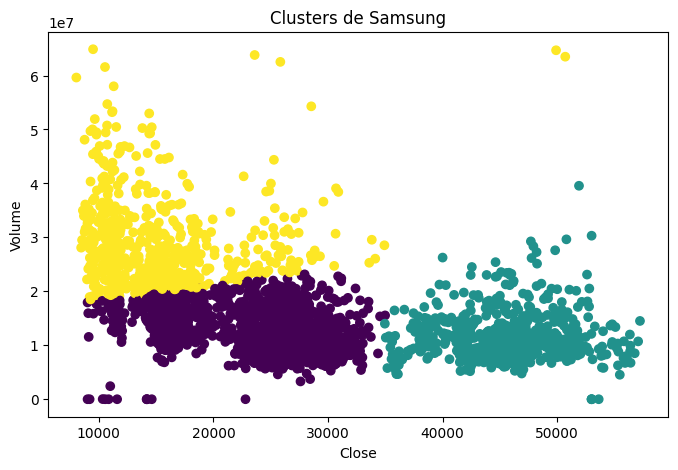

In [6]:
# Gráfico clusters
fig1_path = 'artifacts/samsung_clusters.png'
plt.figure(figsize=(8,5))
plt.scatter(df_samsung['Close'], df_samsung['Volume'], c=df_samsung['Cluster'], cmap='viridis')
plt.xlabel('Close')
plt.ylabel('Volume')
plt.title('Clusters de Samsung')
plt.savefig(fig1_path)
plt.show()

In [7]:
import numpy as np
import seaborn as sns
import joblib

In [9]:
# Cargar datos
df_compra = pd.read_csv('comprar_alquilar.csv')

print("=== DIAGNÓSTICO INICIAL ===")
print(f"Shape del dataset: {df_compra.shape}")
print(f"Columnas: {list(df_compra.columns)}")
print(f"Tipos de datos:")
print(df_compra.dtypes)
print(f"\nPrimeras filas:")
print(df_compra.head())

=== DIAGNÓSTICO INICIAL ===
Shape del dataset: (202, 10)
Columnas: ['ingresos', 'gastos_comunes', 'pago_coche', 'gastos_otros', 'ahorros', 'vivienda', 'estado_civil', 'hijos', 'trabajo', 'comprar']
Tipos de datos:
ingresos          int64
gastos_comunes    int64
pago_coche        int64
gastos_otros      int64
ahorros           int64
vivienda          int64
estado_civil      int64
hijos             int64
trabajo           int64
comprar           int64
dtype: object

Primeras filas:
   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   

   estado_civil  hijos  trabajo  comprar  
0             0

In [10]:
# Verificar datos faltantes
print(f"\nDatos faltantes:")
print(df_compra.isnull().sum())

# Separar características y target
X_compra = df_compra.drop(columns=['comprar'])
y_compra = df_compra['comprar']

print(f"\nTarget (comprar) - valores únicos: {y_compra.unique()}")
print(f"Distribución: \n{y_compra.value_counts()}")


Datos faltantes:
ingresos          0
gastos_comunes    0
pago_coche        0
gastos_otros      0
ahorros           0
vivienda          0
estado_civil      0
hijos             0
trabajo           0
comprar           0
dtype: int64

Target (comprar) - valores únicos: [1 0]
Distribución: 
comprar
0    135
1     67
Name: count, dtype: int64


In [11]:
# PASO 1: PCA completo para análisis
print("\n=== ANÁLISIS PCA ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_compra)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

print(f"Dimensiones después de escalado: {X_scaled.shape}")
print(f"Varianza explicada por componente:")

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
for i in range(len(pca_full.explained_variance_ratio_)):
    print(f"PC{i+1}: {pca_full.explained_variance_ratio_[i]:.3f} ({pca_full.explained_variance_ratio_[i]*100:.1f}%) - Acumulada: {cumulative_variance[i]:.3f} ({cumulative_variance[i]*100:.1f}%)")

# Encontrar componentes necesarios
n_comp_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_comp_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"\nComponentes necesarios:")
print(f"80% varianza: {n_comp_80} componentes")
print(f"90% varianza: {n_comp_90} componentes")


=== ANÁLISIS PCA ===
Dimensiones después de escalado: (202, 9)
Varianza explicada por componente:
PC1: 0.299 (29.9%) - Acumulada: 0.299 (29.9%)
PC2: 0.233 (23.3%) - Acumulada: 0.532 (53.2%)
PC3: 0.117 (11.7%) - Acumulada: 0.649 (64.9%)
PC4: 0.107 (10.7%) - Acumulada: 0.756 (75.6%)
PC5: 0.096 (9.6%) - Acumulada: 0.852 (85.2%)
PC6: 0.056 (5.6%) - Acumulada: 0.909 (90.9%)
PC7: 0.041 (4.1%) - Acumulada: 0.950 (95.0%)
PC8: 0.030 (3.0%) - Acumulada: 0.980 (98.0%)
PC9: 0.020 (2.0%) - Acumulada: 1.000 (100.0%)

Componentes necesarios:
80% varianza: 5 componentes
90% varianza: 6 componentes


In [12]:
# PASO 2: Crear modelos específicos
print("\n=== CREANDO MODELOS ===")

# Modelo 2D para visualización
pipeline_2d = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])
X_2d = pipeline_2d.fit_transform(X_compra)
pca_2d = pipeline_2d.named_steps['pca']

print(f"Modelo 2D:")
print(f"  PC1: {pca_2d.explained_variance_ratio_[0]:.3f} ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
print(f"  PC2: {pca_2d.explained_variance_ratio_[1]:.3f} ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
print(f"  Total: {np.sum(pca_2d.explained_variance_ratio_):.3f} ({np.sum(pca_2d.explained_variance_ratio_)*100:.1f}%)")


=== CREANDO MODELOS ===
Modelo 2D:
  PC1: 0.299 (29.9%)
  PC2: 0.233 (23.3%)
  Total: 0.532 (53.2%)


In [13]:
# Modelo óptimo
pipeline_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp_80))
])
X_opt = pipeline_opt.fit_transform(X_compra)
pca_opt = pipeline_opt.named_steps['pca']

print(f"\nModelo óptimo ({n_comp_80} componentes): {np.sum(pca_opt.explained_variance_ratio_)*100:.1f}% varianza")


Modelo óptimo (5 componentes): 85.2% varianza



=== GENERANDO VISUALIZACIONES ===
Generando Scree Plot...
[OK] Scree Plot generado
Generando grafico de varianza acumulada...
[OK] Varianza acumulada generada
Generando scatter plot 2D (referencia visual)...
[OK] Scatter plot 2D generado
Generando heatmap de loadings (5 componentes)...
[OK] Heatmap de loadings generado
Generando análisis de separabilidad...
[OK] Análisis de separabilidad generado
Generando comparacion de modelos...
[OK] Comparación de modelos generada

[OK] Figura guardada como 'pca_analysis_5comp_focus.png'


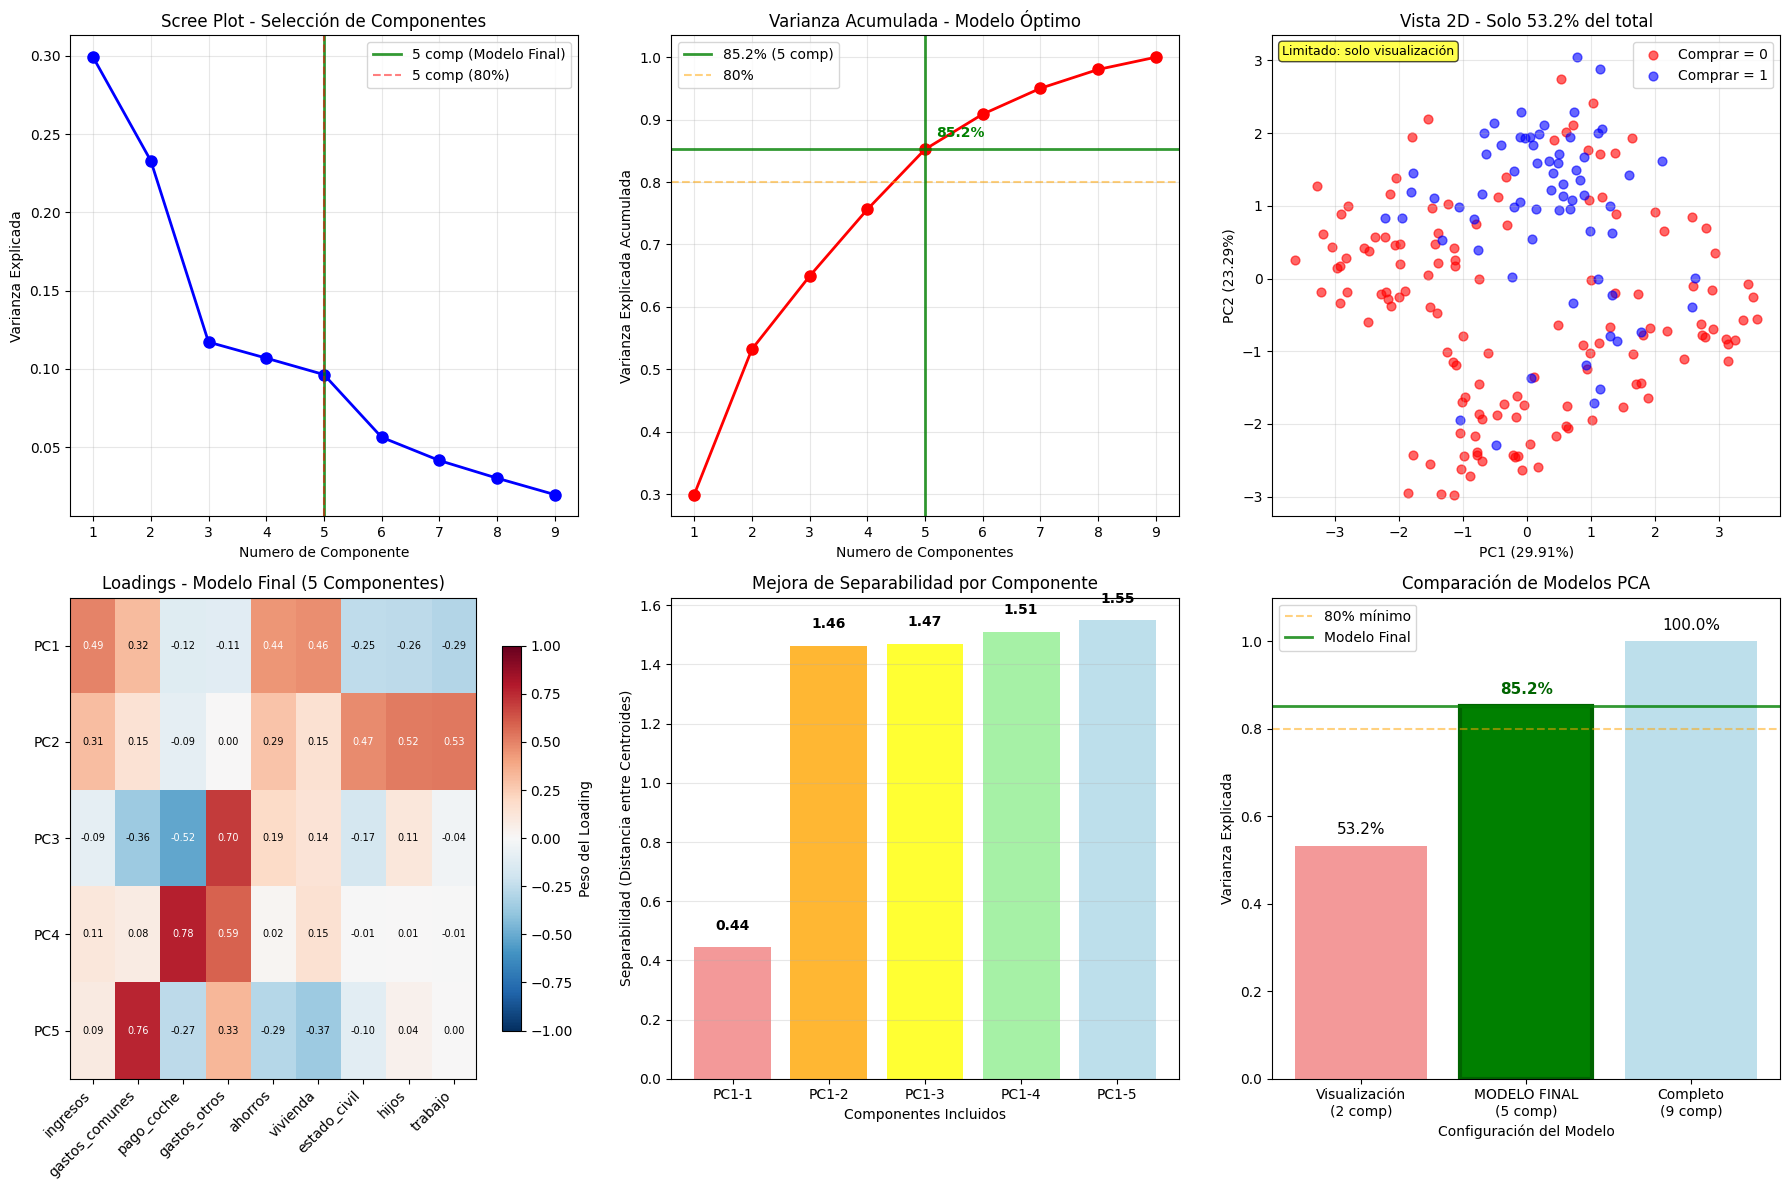


RESUMEN FINAL - MODELO DE 5 COMPONENTES
✓ Modelo principal (5 comp): 85.2% varianza
✓ Información capturada: 85.2%
✓ Información perdida: 14.8%
⚠ Modelo 2D (solo visualización): 53.2% - NO RECOMENDADO para análisis

RECOMENDACIÓN: Usar modelo de 5 componentes para cualquier análisis serio
El modelo 2D se mantiene solo para visualización inicial


In [21]:
# PASO 3: Visualizaciones - ENFOQUE EN MODELO DE 5 COMPONENTES
print("\n=== GENERANDO VISUALIZACIONES ===")

# Crear figura
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

try:
    # 1. Scree Plot - Destacar 5 componentes
    print("Generando Scree Plot...")
    ax1 = axes[0, 0]
    n_show = min(len(pca_full.explained_variance_ratio_), 10)
    ax1.plot(range(1, n_show + 1), pca_full.explained_variance_ratio_[:n_show], 'bo-', linewidth=2, markersize=8)
    ax1.axvline(x=5, color='green', linestyle='-', alpha=0.8, linewidth=2, label='5 comp (Modelo Final)')
    ax1.axvline(x=n_comp_80, color='red', linestyle='--', alpha=0.5, label=f'{n_comp_80} comp (80%)')
    ax1.set_xlabel('Numero de Componente')
    ax1.set_ylabel('Varianza Explicada')
    ax1.set_title('Scree Plot - Selección de Componentes')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    print("[OK] Scree Plot generado")

    # 2. Varianza Acumulada - Destacar 85.2%
    print("Generando grafico de varianza acumulada...")
    ax2 = axes[0, 1]
    ax2.plot(range(1, n_show + 1), cumulative_variance[:n_show], 'ro-', linewidth=2, markersize=8)
    ax2.axhline(y=cumulative_variance[4], color='green', linestyle='-', alpha=0.8, linewidth=2, 
               label=f'85.2% (5 comp)')
    ax2.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, label='80%')
    ax2.axvline(x=5, color='green', linestyle='-', alpha=0.8, linewidth=2)
    ax2.set_xlabel('Numero de Componentes')
    ax2.set_ylabel('Varianza Explicada Acumulada')
    ax2.set_title('Varianza Acumulada - Modelo Óptimo')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.text(5.2, cumulative_variance[4] + 0.02, f'{cumulative_variance[4]:.1%}', 
            fontweight='bold', color='green')
    print("[OK] Varianza acumulada generada")

    # 3. PCA 2D - Solo para referencia visual (mantener pero minimizar importancia)
    print("Generando scatter plot 2D (referencia visual)...")
    ax3 = axes[0, 2]
    
    if 'X_2d' not in locals():
        X_2d = pipeline_2d.transform(X_compra)
    if 'pca_2d' not in locals():
        pca_2d = pipeline_2d.named_steps['pca']
    
    unique_classes = np.unique(y_compra)
    colors = ['red', 'blue']
    
    for i, class_val in enumerate(unique_classes):
        mask = (y_compra == class_val)
        ax3.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=colors[i], 
                   label=f'Comprar = {class_val}', 
                   alpha=0.6, s=40)
    
    var1 = pca_2d.explained_variance_ratio_[0]
    var2 = pca_2d.explained_variance_ratio_[1]
    ax3.set_xlabel(f'PC1 ({var1:.2%})')
    ax3.set_ylabel(f'PC2 ({var2:.2%})')
    ax3.set_title(f'Vista 2D - Solo {np.sum(pca_2d.explained_variance_ratio_):.1%} del total')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    # Agregar nota de limitación
    ax3.text(0.02, 0.98, 'Limitado: solo visualización', transform=ax3.transAxes, 
            fontsize=9, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    print("[OK] Scatter plot 2D generado")

    # 4. Heatmap de loadings - MODELO DE 5 COMPONENTES
    print("Generando heatmap de loadings (5 componentes)...")
    ax4 = axes[1, 0]
    
    if 'pca_opt' not in locals():
        pca_opt = pipeline_opt.named_steps['pca']
    
    # USAR 5 COMPONENTES COMPLETOS
    loadings = pca_opt.components_[:5, :]  # Forzar 5 componentes
    
    im = ax4.imshow(loadings, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(X_compra.columns)))
    ax4.set_xticklabels(X_compra.columns, rotation=45, ha='right')
    ax4.set_yticks(range(5))
    ax4.set_yticklabels([f'PC{i+1}' for i in range(5)])
    ax4.set_title('Loadings - Modelo Final (5 Componentes)')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
    cbar.set_label('Peso del Loading')
    
    # Añadir valores en el heatmap
    for i in range(5):
        for j in range(len(X_compra.columns)):
            color = 'white' if abs(loadings[i, j]) > 0.4 else 'black'
            ax4.text(j, i, f'{loadings[i, j]:.2f}', 
                    ha='center', va='center', 
                    color=color, fontsize=7)
    print("[OK] Heatmap de loadings generado")

    # 5. Separabilidad mejorada - Comparar PC1 vs PC1+PC2+...+PC5
    print("Generando análisis de separabilidad...")
    ax5 = axes[1, 1]
    
    # Calcular separabilidad acumulativa
    separabilities = []
    component_labels = []
    
    for n_comp in range(1, 6):
        X_temp = X_opt[:, :n_comp]  # Usar primeros n componentes
        
        # Calcular distancia entre centroides
        y_numeric = pd.factorize(y_compra)[0]
        class_0_centroid = X_temp[y_numeric == 0].mean(axis=0)
        class_1_centroid = X_temp[y_numeric == 1].mean(axis=0)
        
        # Distancia euclidiana entre centroides
        distance = np.linalg.norm(class_1_centroid - class_0_centroid)
        separabilities.append(distance)
        component_labels.append(f'PC1-{n_comp}')
    
    # Gráfico de barras
    bars = ax5.bar(range(len(separabilities)), separabilities, 
                   color=['lightcoral', 'orange', 'yellow', 'lightgreen', 'lightblue'], 
                   alpha=0.8)
    
    ax5.set_xlabel('Componentes Incluidos')
    ax5.set_ylabel('Separabilidad (Distancia entre Centroides)')
    ax5.set_title('Mejora de Separabilidad por Componente')
    ax5.set_xticks(range(len(component_labels)))
    ax5.set_xticklabels(component_labels)
    
    # Valores en las barras
    for bar, sep in zip(bars, separabilities):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{sep:.2f}', ha='center', va='bottom', fontweight='bold')
    
    ax5.grid(True, alpha=0.3, axis='y')
    print("[OK] Análisis de separabilidad generado")

    # 6. Comparación de modelos - DESTACAR EL DE 5 COMPONENTES
    print("Generando comparacion de modelos...")
    ax6 = axes[1, 2]
    
    var_2d = np.sum(pca_2d.explained_variance_ratio_)
    var_opt = np.sum(pca_opt.explained_variance_ratio_)
    
    model_info = {
        f'Visualización\n(2 comp)': var_2d,
        f'MODELO FINAL\n(5 comp)': var_opt,
        f'Completo\n({len(X_compra.columns)} comp)': 1.0
    }
    
    names = list(model_info.keys())
    variances = list(model_info.values())
    colors_bars = ['lightcoral', 'lightgreen', 'lightblue']
    
    bars = ax6.bar(range(len(names)), variances, 
                   color=colors_bars, alpha=0.8)
    
    # Destacar el modelo final
    bars[1].set_color('green')
    bars[1].set_alpha(1.0)
    bars[1].set_linewidth(3)
    bars[1].set_edgecolor('darkgreen')
    
    ax6.set_xlabel('Configuración del Modelo')
    ax6.set_ylabel('Varianza Explicada')
    ax6.set_title('Comparación de Modelos PCA')
    ax6.set_xticks(range(len(names)))
    ax6.set_xticklabels(names, fontsize=10)
    ax6.set_ylim(0, 1.1)
    
    # Valores en las barras
    for i, (bar, var) in enumerate(zip(bars, variances)):
        height = bar.get_height()
        fontweight = 'bold' if i == 1 else 'normal'
        color = 'darkgreen' if i == 1 else 'black'
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{var:.1%}', ha='center', va='bottom', 
                fontweight=fontweight, color=color, fontsize=11)
    
    # Líneas de referencia
    ax6.axhline(y=0.8, color='orange', linestyle='--', alpha=0.5, label='80% mínimo')
    ax6.axhline(y=var_opt, color='green', linestyle='-', alpha=0.8, linewidth=2, 
               label='Modelo Final')
    ax6.legend()
    print("[OK] Comparación de modelos generada")

    # Ajustar layout y guardar
    plt.tight_layout()
    plt.savefig('artifacts/pca_analysis_5comp_focus.png', dpi=300, bbox_inches='tight')
    print("\n[OK] Figura guardada como 'pca_analysis_5comp_focus.png'")
    plt.show()

except Exception as e:
    print(f"ERROR en visualizaciones: {e}")
    import traceback
    traceback.print_exc()

# Resumen final corregido
print(f"\n{'='*60}")
print("RESUMEN FINAL - MODELO DE 5 COMPONENTES")
print(f"{'='*60}")
print(f"✓ Modelo principal (5 comp): {np.sum(pca_opt.explained_variance_ratio_)*100:.1f}% varianza")
print(f"✓ Información capturada: {np.sum(pca_opt.explained_variance_ratio_)*100:.1f}%")
print(f"✓ Información perdida: {(1-np.sum(pca_opt.explained_variance_ratio_))*100:.1f}%")
print(f"⚠ Modelo 2D (solo visualización): {np.sum(pca_2d.explained_variance_ratio_)*100:.1f}% - NO RECOMENDADO para análisis")
print(f"\nRECOMENDACIÓN: Usar modelo de 5 componentes para cualquier análisis serio")
print(f"El modelo 2D se mantiene solo para visualización inicial")

In [18]:
# PASO 4: Análisis detallado de componentes
print(f"\n{'='*60}")
print("ANÁLISIS DETALLADO DE COMPONENTES PRINCIPALES")
print(f"{'='*60}")

# Información de los modelos
print(f"Modelo 2D: {np.sum(pca_2d.explained_variance_ratio_)*100:.1f}% varianza")
print(f"Modelo óptimo (5 comp): {np.sum(pca_opt.explained_variance_ratio_)*100:.1f}% varianza")

# Analizar cada componente principal
for i in range(min(4, n_comp_80)):
    print(f"\n--- PC{i+1} ({pca_opt.explained_variance_ratio_[i]*100:.1f}% varianza) ---")
    
    # Variables más influyentes
    component_loadings = pca_opt.components_[i, :]
    feature_importance = list(zip(X_compra.columns, component_loadings))
    feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Variables más influyentes:")
    for j, (feature, loading) in enumerate(feature_importance[:5]):
        direction = "positiva" if loading > 0 else "negativa"
        print(f"  {j+1}. {feature}: {loading:.3f} (influencia {direction})")
    
    # Interpretación práctica
    top_positive = [f for f, l in feature_importance if l > 0.3][:2]
    top_negative = [f for f, l in feature_importance if l < -0.3][:2]
    
    if top_positive or top_negative:
        print(f"  Interpretación práctica:")
        if top_positive:
            print(f"    Alto PC{i+1} = Mayor: {', '.join(top_positive)}")
        if top_negative:
            print(f"    Alto PC{i+1} = Menor: {', '.join(top_negative)}")


ANÁLISIS DETALLADO DE COMPONENTES PRINCIPALES
Modelo 2D: 53.2% varianza
Modelo óptimo (5 comp): 85.2% varianza

--- PC1 (29.9% varianza) ---
Variables más influyentes:
  1. ingresos: 0.494 (influencia positiva)
  2. vivienda: 0.463 (influencia positiva)
  3. ahorros: 0.445 (influencia positiva)
  4. gastos_comunes: 0.318 (influencia positiva)
  5. trabajo: -0.290 (influencia negativa)
  Interpretación práctica:
    Alto PC1 = Mayor: ingresos, vivienda

--- PC2 (23.3% varianza) ---
Variables más influyentes:
  1. trabajo: 0.527 (influencia positiva)
  2. hijos: 0.522 (influencia positiva)
  3. estado_civil: 0.469 (influencia positiva)
  4. ingresos: 0.307 (influencia positiva)
  5. ahorros: 0.288 (influencia positiva)
  Interpretación práctica:
    Alto PC2 = Mayor: trabajo, hijos

--- PC3 (11.7% varianza) ---
Variables más influyentes:
  1. gastos_otros: 0.702 (influencia positiva)
  2. pago_coche: -0.516 (influencia negativa)
  3. gastos_comunes: -0.363 (influencia negativa)
  4. aho

In [19]:
# PASO 5: Métricas de evaluación
print(f"\n{'='*50}")
print("MÉTRICAS DE EVALUACIÓN")
print(f"{'='*50}")

from sklearn.metrics import silhouette_score

# Evaluar separabilidad con diferentes números de componentes
for name, n_comp in [('2D', 2), ('Óptimo', n_comp_80)]:
    if name == '2D':
        X_eval = X_2d
    else:
        X_eval = X_opt
    
    # Convertir y_compra a numérico si es necesario
    y_numeric = pd.factorize(y_compra)[0]
    
    # Silhouette score
    sil_score = silhouette_score(X_eval, y_numeric)
    
    # Separabilidad por componente
    separability = []
    for i in range(min(3, X_eval.shape[1])):
        pc_values = X_eval[:, i]
        class_means = [pc_values[y_numeric == c].mean() for c in np.unique(y_numeric)]
        sep = abs(class_means[1] - class_means[0]) if len(class_means) == 2 else 0
        separability.append(sep)
    
    print(f"\n{name} ({n_comp if isinstance(n_comp, int) else len(X_eval[0])} componentes):")
    print(f"  Silhouette Score: {sil_score:.3f}")
    print(f"  Separabilidad PC1: {separability[0]:.3f}")
    if len(separability) > 1:
        print(f"  Separabilidad PC2: {separability[1]:.3f}")


MÉTRICAS DE EVALUACIÓN

2D (2 componentes):
  Silhouette Score: 0.098
  Separabilidad PC1: 0.444
  Separabilidad PC2: 1.395

Óptimo (5 componentes):
  Silhouette Score: 0.054
  Separabilidad PC1: 0.444
  Separabilidad PC2: 1.395


In [20]:
# PASO 6: Guardar modelos y resultados
print(f"\n{'='*50}")
print("GUARDANDO MODELOS Y RESULTADOS")
print(f"{'='*50}")

# Guardar modelos
models_to_save = {
    'pca_2d_visualization': pipeline_2d,
    f'pca_optimal_{n_comp_80}comp': pipeline_opt
}

for name, model in models_to_save.items():
    filename = f'artifacts/{name}.joblib'
    joblib.dump(model, filename)
    print(f"[OK] Guardado: {filename}")

# Guardar resultados en CSV para análisis posterior
results_df = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'comprar': y_compra
})
results_df.to_csv('artifacts/pca_2d_results.csv', index=False)
print("[OK] Resultados 2D guardados: pca_2d_results.csv")

# Guardar modelo completo
if n_comp_80 <= 5:  # Solo si no son demasiados componentes
    results_full_df = pd.DataFrame(X_opt, 
                                  columns=[f'PC{i+1}' for i in range(n_comp_80)])
    results_full_df['comprar'] = y_compra
    results_full_df.to_csv(f'artifacts/pca_{n_comp_80}d_results.csv', index=False)
    print(f"[OK] Resultados {n_comp_80}D guardados: pca_{n_comp_80}d_results.csv")


GUARDANDO MODELOS Y RESULTADOS
[OK] Guardado: artifacts/pca_2d_visualization.joblib
[OK] Guardado: artifacts/pca_optimal_5comp.joblib
[OK] Resultados 2D guardados: pca_2d_results.csv
[OK] Resultados 5D guardados: pca_5d_results.csv
